## Sensor Selection

This is the fundamental greedy algorithm implementation. 

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

def get_labels_from_df(df, from_idx, to_idx, label_idx):
    labeled_edges = {}
    for e in df.itertuples():
        labeled_edges[(e[from_idx], e[to_idx])] = e[label_idx]
    return labeled_edges

In [2]:
from scipy.sparse import linalg

def flow_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    j = 0
    U = []
    index = {}
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    b = -B.dot(f0)
 
    A = B[np.ix_(np.arange(B.shape[0]), U)]

    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]

    pred_flows = {}
    
    for e in G.edges():
        if e in labelled_flows:
            pred_flows[e] = labelled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
    
    return pred_flows

In [3]:
def mse(pred_labels, labeled_edges):
    return sum([(v - pred_labels[k]) ** 2 for k, v in labeled_edges.items()]) / len(labeled_edges)     

In [209]:
from tqdm.notebook import tqdm
from multiprocess import Pool 
import heapq

def choose_sensors(G, labeled_edges, predict, evaluate, k=None, lazy=False, cores=4):
    """
    Choose `k` sensors greedily to optimize the prediction given by `predict` for ground truth `labels`
    based on loss function `evaluate` (lower loss is better). 
    
    Parameters:
        -- G: networkx graph
        -- labeled_edges: dict {edge : value}
        -- predict: function taking G, labeled_edges -> prediction
        -- evaluate: prediction, true_values -> loss
    """
    if k == None:
        k = int(G.number_of_edges() / 50)
    
    sensors = []
        
    # Find value of adding each edge not in the set
    current = evaluate(predict(G, {}), labeled_edges)

    with Pool(cores) as pool:
        deltas = pool.map(lambda e: (evaluate(predict(G, {e : labeled_edges[e]}), labeled_edges) - current, e), 
                          labeled_edges)

    heapq.heapify(deltas)
#     print("len(deltas):", len(deltas))
    
    # Greedily select sensors
    if lazy:
        for i in tqdm(range(k)):
            current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)
#             print("iteration {}, current {}".format(i, current))

            # Current top 
            _, s = heapq.heappop(deltas)
            delta = evaluate(predict(G, {e: labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}), 
                             labeled_edges) - current
            
            if len(deltas) == 0:
                sensors.append(s)
                continue

            # Next top
            delta_next, s_next = heapq.heappop(deltas)
            delta_next -= current
            
#             print("sensor {} delta {}".format(s, delta))
#             print("next top sensor {} delta {}".format(s_next, delta_next))
#             print("deltas: {}".format(deltas))
            
#             if delta_next <= delta:
#                 heapq.heappush(deltas, (delta_next, s_next))
                
            # If the change drops it below the next best, recalculate the next best and continue
            while delta > delta_next:
#                 print("sensor {} delta {}".format(s, delta))
#                 print("next top sensor {} delta {}".format(s_next, delta_next))
                delta_next = evaluate(predict(G, {e: labeled_edges[e] for e in sensors} | {s_next : labeled_edges[s_next]}), 
                             labeled_edges) - current
                if delta_next < delta:
                    heapq.heappush(deltas, (delta, s))
                    delta, s = delta_next, s_next
#                     print("next > delta, len(deltas)", len(deltas))
                else:
                    heapq.heappush(deltas, (delta_next, s_next))
#                     print("delta > next, len(deltas):", len(deltas))
                    delta_next, s_next = heapq.heappop(deltas)
                    
                    if delta <= delta_next:
                        heapq.heappush(deltas, (delta_next, s_next))
                        break
                
#             print("iteration", i, "len(deltas):", len(deltas))
#             print("selecting sensor {} delta {}, next sensor {} has delta {}".format(s, delta, s_next, delta_next))
            sensors.append(s)
#             print()
    else:
        for i in tqdm(range(k)):
            current = evaluate(predict(G, {e: labeled_edges[e] for e in sensors}), labeled_edges)
            # print("iteration {}, current {}".format(i, current))
            opt, opt_cost = None, float("inf")
            for s in G.edges():
                if s not in sensors:
                    cost = evaluate(predict(G, {e : labeled_edges[e] for e in sensors} | {s : labeled_edges[s]}),
                                   labeled_edges)
                    # print("sensor {} cost {} opt {}".format(s, cost, opt_cost))
                    if cost < opt_cost:
                        opt, opt_cost = s, cost
            sensors.append(opt)
        
    return sensors

### Testing

Should choose one node from each cluster

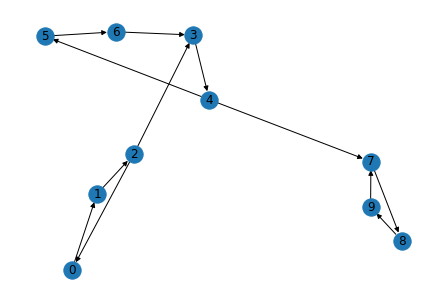

In [180]:
J = nx.DiGraph()

J.add_edge(0,1)
J.add_edge(1,2)
J.add_edge(2,0)
J.add_edge(2,3)
J.add_edge(3,4)
J.add_edge(4,5)
J.add_edge(6,3)
J.add_edge(5,6)
J.add_edge(4,7)
J.add_edge(7,8)
J.add_edge(8,9)
J.add_edge(9,7)

flows = {}

flows[(0,1)] = 10.
flows[(1,2)] = 10
flows[(2,0)] = 10.
flows[(2,3)] = 0.
flows[(3,4)] = 10.
flows[(4,5)] = 10.
flows[(6,3)] = 10
#flows[(6,4)] = 10.
flows[(5,6)] = 10.
flows[(4,7)] = 0
flows[(7,8)] = 10
flows[(8,9)] = 10
flows[(9,7)] = 10

np.random.seed(1000)
nx.draw(J, with_labels=True)

In [182]:
opt = choose_sensors(J, flows, flow_prediction, mse, 3)
opt

  0%|          | 0/3 [00:00<?, ?it/s]

[(3, 4), (0, 1), (9, 7)]

In [183]:
flow_prediction(J, {s : flows[s] for s in opt})

{(0, 1): 10.0,
 (1, 2): 10.000000000001995,
 (2, 0): 9.999999999978003,
 (2, 3): 3.5998759528865776e-11,
 (3, 4): 10.0,
 (4, 5): 9.999999999958003,
 (4, 7): 2.3994806142013658e-11,
 (5, 6): 9.999999999950004,
 (6, 3): 9.999999999952006,
 (7, 8): 10.000000000005995,
 (8, 9): 9.999999999997996,
 (9, 7): 10}

In [184]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt}))

7.471757903305644e-22

In [210]:
opt_lazy = choose_sensors(J, flows, flow_prediction, mse, lazy=True, k=len(J.edges))
opt_lazy

  0%|          | 0/12 [00:00<?, ?it/s]

[(3, 4),
 (0, 1),
 (7, 8),
 (9, 7),
 (1, 2),
 (2, 0),
 (2, 3),
 (4, 5),
 (8, 9),
 (5, 6),
 (6, 3),
 (4, 7)]

In [211]:
mse(flows, flow_prediction(J, {s : flows[s] for s in opt_lazy[:3]}))

2.4772853103026e-21

## Testing - Synthetic Flows and Non-Negative Solution

In [11]:
# Author: Vlad Niculae 
#         Lars Buitinck 
# Author: Chih-Jen Lin, National Taiwan University (original projected gradient
#     NMF implementation)
# Author: Anthony Di Franco (original Python and NumPy port)
# License: BSD 3 clause

from sklearn.utils.extmath import safe_sparse_dot
from scipy.sparse import csr_matrix, issparse
from scipy.optimize import fmin_l_bfgs_b

def safe_fro(X, squared=False):
    if issparse(X):
        nrm = np.sum(X.data ** 2)
    else:
        if hasattr(X, 'A'):
            X = X.A
        nrm = np.sum(X ** 2)
    return nrm if squared else np.sqrt(nrm)
     

# Authors: Mathieu Blondel, Vlad Niculae
def nls_lbfgs_b(X, Y, W_init=None, l1_reg=0, l2_reg=0, max_iter=5000, tol=1e-3, callback=None):
    """Non-negative least squares solver using L-BFGS-B.
        
    Solves for W in
    min 0.5 ||Y - XW||^2_F + + l1_reg * sum(W) + 0.5 * l2_reg * ||W||^2_F
    
    """
    n_samples, n_features = X.shape
    n_targets = Y.shape[1]
    G = safe_sparse_dot(X.T, X)
    Xy = safe_sparse_dot(X.T, Y)

    def f(w, *args):
        W = w.reshape((n_features, n_targets))
        diff = (safe_sparse_dot(X, W) - Y)
        diff = diff.A if hasattr(diff, 'A') else diff
        res = 0.5 * np.sum(diff ** 2)
        if l2_reg:
            res += 0.5 * l2_reg * np.sum(W ** 2)
        if l1_reg:
            res += l1_reg * np.sum(W)
        return res

    def fprime(w, *args):
        W = w.reshape((n_features, n_targets))
        #grad = (np.dot(G, W) - Xy).ravel()
        grad = (safe_sparse_dot(G, W) - Xy).ravel()
        if l2_reg:
            grad += l2_reg * w
        if l1_reg:
            grad += l1_reg
        return grad

    if W_init is None:
        W = np.zeros((n_features * n_targets,), dtype=np.float64)
    else:
        W = W_init.ravel().copy()
    W, residual, d = fmin_l_bfgs_b(
                f, x0=W, fprime=fprime, pgtol=tol,
                bounds=[(0, None)] * n_features * n_targets,
                maxiter=max_iter,
                callback=callback)
    
    # testing reveals that sometimes, very small negative values occur
    W[W < 0] = 0
    
    if l1_reg:
        residual -= l1_reg * np.sum(W)
    if l2_reg:
        residual -= 0.5 * l2_reg * np.sum(W ** 2)
    residual = np.sqrt(2 * residual)
    if d['warnflag'] > 0:
        print("L-BFGS-B failed to converge")
    
    return W.reshape((n_features, n_targets)), residual

In [12]:
import scipy 

def flow_prediction_nls(G, labelled_flows, lamb=1e-6):
    '''
        Flow prediction with non-negative least squares
    '''
    n_labelled_edges = len(labelled_flows)
    b = np.zeros(n_labelled_edges)
    B = nx.incidence_matrix(G, oriented=True)
    f0 = np.zeros(G.number_of_edges())

    i = 0
    j = 0
    U = []
    index = {}
    for e in G.edges():
        if e in labelled_flows:
            f0[i] = labelled_flows[e]
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    b = -B.dot(f0)
 
    A = B[np.ix_(np.arange(B.shape[0]), U)]
    
    #X_wide = np.random.uniform(low=0, high=1, size=(50, 100))
    #Y_wide = np.random.uniform(low=0, high=1, size=(50, 1))
    #W, resid = nls_projgrad(X_wide, Y_wide)
    
    #res = linalg.lsmr(A, b, damp=lamb)
    A = A.tocsr()
    #b = scipy.sparse.csr_matrix(b.reshape(b.shape[0], 1))
    b = scipy.sparse.csr_matrix(b.reshape(b.shape[0],1))
    
    res = nls_lbfgs_b(A, b, l2_reg=lamb)
    x = res[0]

    pred_flows = {}
    
    for e in G.edges():
        if e in labelled_flows:
            pred_flows[e] = np.array([labelled_flows[e]])
        else:
            pred_flows[e] = x[index[e]]
    
            
    return pred_flows

In [13]:
def speed_prediction(G, labelled_flows, lamb=1e-6):
    '''
        Speed prediction.
    '''
    n_labelled_edges = len(labelled_flows)
    line_G = nx.line_graph(G)
    A = nx.adjacency_matrix(line_G)
    f0 = []
    
    A.data = A.data / np.repeat(np.add.reduceat(A.data, A.indptr[:-1]), np.diff(A.indptr))
   
    U = []
    L = []
    i = 0
    j = 0
    index = {}
    for e in line_G.nodes():
        if e in labelled_flows:
            f0.append(labelled_flows[e])
            L.append(i)
        else:
            U.append(i)
            index[e] = j
            j = j + 1
        i = i + 1

    PUL = A[np.ix_(U, L)]
    f0 = np.array(f0)
    b = PUL.dot(f0)
    PUU = A[np.ix_(U, U)]
    A = scipy.sparse.identity(PUU.shape[0])-PUU   
    res = linalg.lsmr(A, b, damp=lamb)
    x = res[0]
    
    pred_flows = {}

    for e in G.edges:
        if e in labelled_flows:
            pred_flows[e] = labeled_flows[e]
        else:
            pred_flows[e] = x[index[e]]
            
    return pred_flows

## Testing - Small Network

In [14]:
city = "small"

edgelist = pd.read_csv("out/" + city + ".results.csv")
edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,1614922744,1614922747,23.141939,2,29.0576,0.0,0.00
1,1,269459339,269459341,60.826398,5,29.0576,14274.0,25.65
2,2,1621320618,1621320622,109.464966,2,29.0576,1149.0,27.70
3,3,269459229,269459230,160.720645,3,29.0576,7974.0,25.03
4,4,607954833,1613371666,173.017706,3,29.0576,6504.0,26.02


In [15]:
G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)

In [17]:
from copy import deepcopy

dummy = "dummy"

for v in deepcopy(G.nodes()):
    if G.out_degree(v) == 0:
        G.add_edge(v, dummy)
    if G.in_degree(v) == 0:
        G.add_edge(dummy, v)

In [18]:
nodes = pd.read_csv("out/" + city + ".nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
269459457,-118.215300,34.056067
317640716,-118.221778,34.036254
317640717,-118.221770,34.036083
317640718,-118.221753,34.035806
317640719,-118.221718,34.035521


In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}

In [28]:
labeled_flows = get_labels_from_df(edgelist, 2, 3, -2)
k = int(len(labeled_flows) / 10)

In [29]:
opt_sensors = choose_sensors(G, labeled_flows, flow_prediction_nls, mse, lazy=True, k=k, cores=8)

L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge
L-BFGS-B failed to converge


  0%|          | 0/122 [00:00<?, ?it/s]

L-BFGS-B failed to converge
L-BFGS-B failed to converge


In [30]:
errs = {}

for i in tqdm(range(len(opt_sensors))):
    preds = flow_prediction_nls(G, {s: labeled_flows[s] for s in opt_sensors[:i]})
    errs[i] = mse(preds, labeled_flows) ** (1 / 2)

  0%|          | 0/122 [00:00<?, ?it/s]

L-BFGS-B failed to converge


In [141]:
"""
Randomly select k edges from the graph.
"""
def choose_sensors_random(G, k=None, dummy=None):
    if k == None:
        k = int(G.number_of_edges() / 50)
        
    H = G.__class__()
    H.add_nodes_from(G)
    H.add_edges_from(G.edges)
    
    if dummy in H.nodes:
        H.remove_node(dummy)
        
    choice = np.random.choice(H.number_of_edges(), k, replace=False)
    selected = []
    for i, e in enumerate(H.edges):
        if i in choice:
            selected.append(e)
        
    return selected

rand_sensors = choose_sensors_random(G, k=k, dummy="dummy")
len(rand_sensors)

122

In [52]:
rand_errs = {}

for i in tqdm(range(len(rand_sensors))):
    preds = flow_prediction_nls(G, {s: labeled_flows[s] for s in rand_sensors[:i]})
    rand_errs[i] = mse(preds, labeled_flows) ** (1 / 2)

  0%|          | 0/122 [00:00<?, ?it/s]

L-BFGS-B failed to converge
L-BFGS-B failed to converge


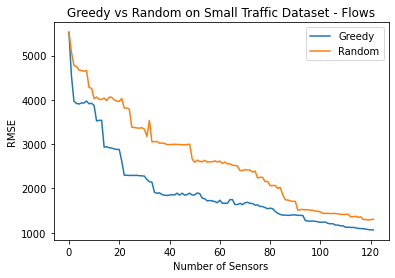

In [54]:
fig, ax = plt.subplots()
ax.plot(range(len(errs.values())), errs.values(), label="Greedy")
ax.plot(range(len(rand_errs.values())), rand_errs.values(), label="Random")
ax.legend()
plt.xlabel("Number of Sensors")
plt.ylabel("RMSE")
plt.title("Greedy vs Random on Small Traffic Dataset - Flows")
plt.show()

In [ ]:
G.remove_node(dummy)

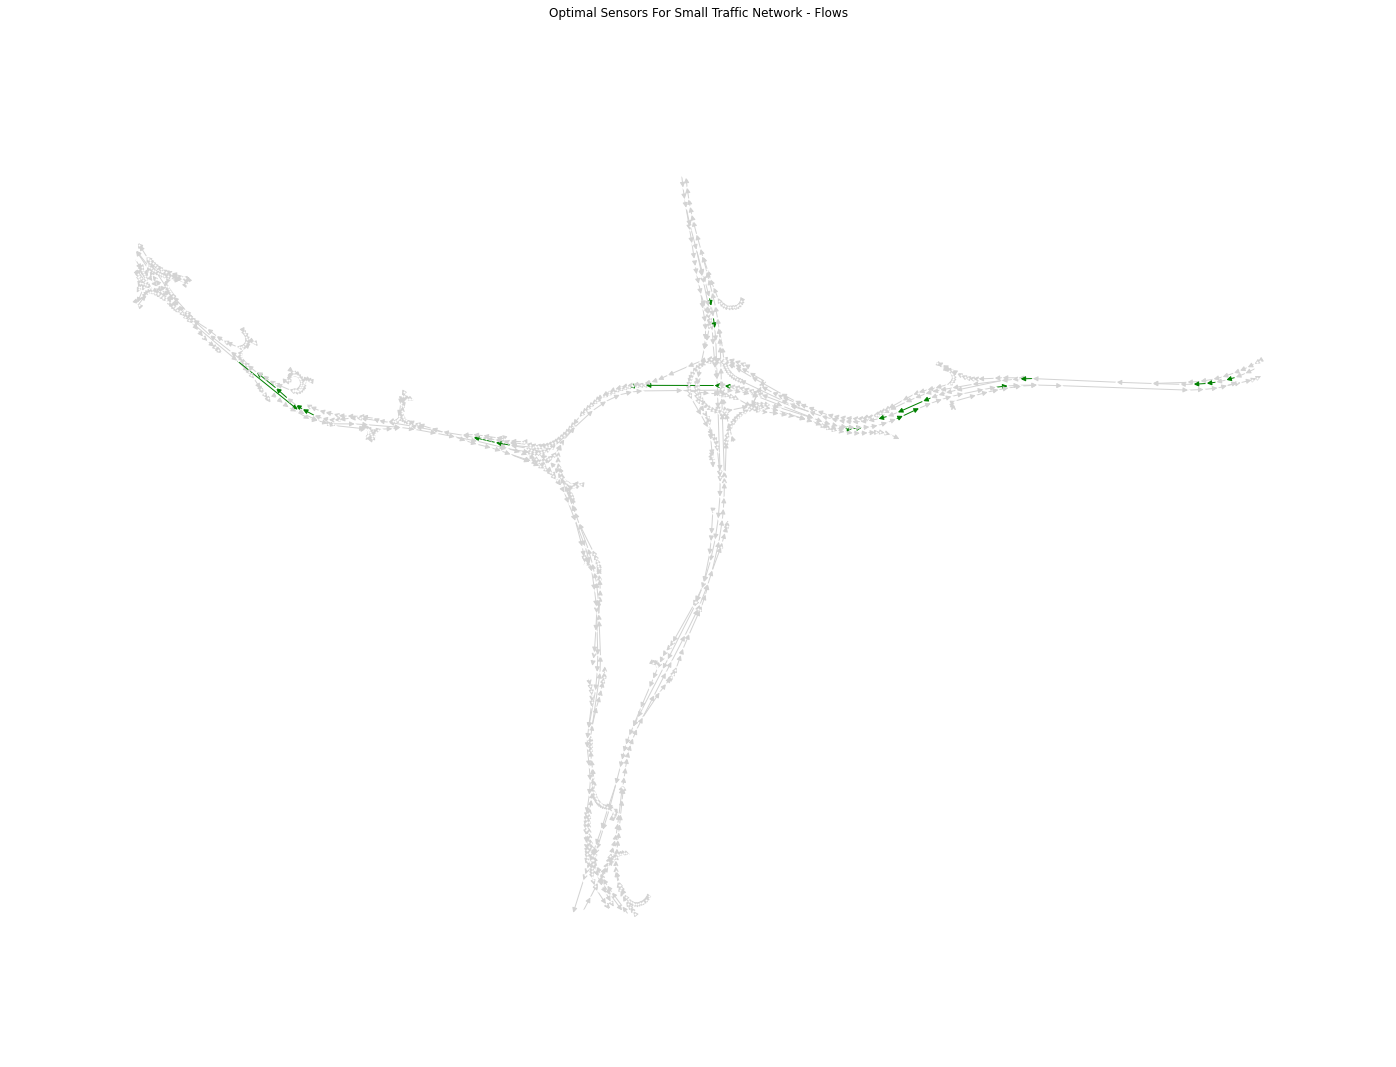

In [60]:
plt.figure(figsize=[3 * 6.4, 3 * 4.8])
edge_colors = ["green" if (u, v) in opt_sensors[:25] or (v, u) in opt_sensors[:25] else "lightgray" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)
plt.title("Optimal Sensors For Small Traffic Network - Flows")
plt.show()

In [61]:
mse(flow_prediction_nls(G, {s: labeled_flows[s] for s in opt_sensors}), labeled_flows) ** 2

array([4.47258157e+11])

In [62]:
preds = flow_prediction_nls(G, {s: labeled_flows[s] for s in opt_sensors})

In [71]:
labeled_speeds = get_labels_from_df(edgelist, 2, 3, -1)

In [138]:
opt_sensors = choose_sensors(G, labeled_speeds, speed_prediction, mse, lazy=True, k=600, cores=8)

  0%|          | 0/600 [00:00<?, ?it/s]

In [142]:
rand_sensors = choose_sensors_random(G, k=600)

In [143]:
len(rand_sensors)

600

In [144]:
errs, rand_errs = {}, {}

for i in tqdm(range(len(opt_sensors))):
    preds = speed_prediction(G, {s: labeled_speeds[s] for s in opt_sensors[:i]})
    errs[i] = mse(preds, labeled_speeds) ** (1 / 2)
    
    random_preds = speed_prediction(G, {s: labeled_speeds[s] for s in rand_sensors[:i]})
    rand_errs[i] = mse(random_preds, labeled_speeds) ** (1 / 2)

  0%|          | 0/600 [00:00<?, ?it/s]

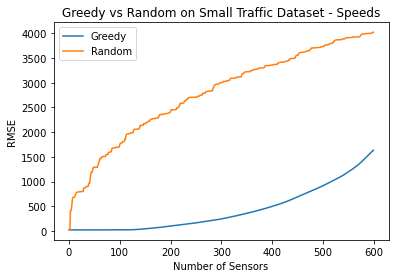

In [145]:
fig, ax = plt.subplots()
ax.plot(range(len(errs.values())), errs.values(), label="Greedy")
ax.plot(range(len(rand_errs.values())), rand_errs.values(), label="Random")
ax.legend()
plt.xlabel("Number of Sensors")
plt.ylabel("RMSE")
plt.title("Greedy vs Random on Small Traffic Dataset - Speeds")
plt.show()

In [ ]:
plt.figure(figsize=[3 * 6.4, 3 * 4.8])

edge_colors = ["green" if (u, v) in opt_sensors or (v, u) in opt_sensors else "lightgray" for u, v in G.edges()]
nx.draw(G, pos=positions, node_size=1, node_color="white", edge_color=edge_colors)

In [ ]:
preds = speed_prediction(G, {s: labeled_flows[s] for s in opt_sensors})
mse(preds, labeled_speeds)

In [ ]:
preds

## Benchmarks

### TODO

Get benchmarks from active learning paper

## Error Metrics

In [ ]:
def geh(pred, actual):
    if pred == actual == 0:
        return np.array([0])
    return np.sqrt((2 * (pred - actual) ** 2) / (pred + actual))

In [ ]:
def mape(pred_labels, labeled_edges):
    return 100 * sum([abs((v - pred_labels[k]) / v) for k, v in labeled_edges.items()]) / len(labeled_edges) 

# Some Results

## Synthetic Flows

In [212]:
def synthetic_flows(G, b=0.02, epsilon=0.1):
    B = nx.incidence_matrix(G, oriented=True)
    u, s, vh = scipy.linalg.svd(B.todense())
    ss = np.zeros(vh.shape[0])
    ss[:s.shape[0]] = s
    
    vec = np.zeros(vh.shape[0])

    for i in range(vh.shape[0]):
        vec = vec + b / (ss[i]+epsilon) * vh[i]
        
    flows = {}
    
    i = 0
    for e in G.edges():
        flows[e] = vec[i] * 1000
        i = i + 1
        
    return flows

In [248]:
labeled_synthetic_flows = synthetic_flows(G)

In [249]:
for v in deepcopy(G.nodes()):
    if G.out_degree(v) == 0:
        G.add_edge(v, dummy)
    if G.in_degree(v) == 0:
        G.add_edge(dummy, v)

In [250]:
opt_sensors = choose_sensors(G, labeled_synthetic_flows, flow_prediction, mse, lazy=True, k=600, cores=10)

  0%|          | 0/600 [00:00<?, ?it/s]

In [244]:
G.remove_node(dummy)

In [251]:
random_sensors = choose_sensors_random(power_graph, k=600)

In [252]:
errs, rand_errs = {}, {}

for i in tqdm(range(len(opt_sensors))):
    preds = flow_prediction(G, {s: labeled_synthetic_flows[s] for s in opt_sensors[:i]})
    errs[i] = mse(preds, labeled_synthetic_flows) ** (1 / 2)
    
    random_preds = flow_prediction(G, {s: labeled_synthetic_flows[s] for s in rand_sensors[:i]})
    rand_errs[i] = mse(random_preds, labeled_synthetic_flows) ** (1 / 2)

  0%|          | 0/600 [00:00<?, ?it/s]

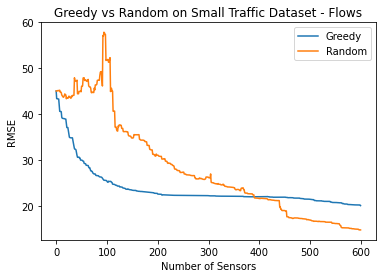

In [253]:
fig, ax = plt.subplots()
ax.plot(range(len(errs.values())), errs.values(), label="Greedy")
ax.plot(range(len(rand_errs.values())), rand_errs.values(), label="Random")
ax.legend()
plt.xlabel("Number of Sensors")
plt.ylabel("RMSE")
plt.title("Greedy vs Random on Small Traffic Dataset - Flows")
plt.show()

## Some Real Graphs

### Power Flows

In [219]:
power_edgelist = pd.read_csv("data/power_net.csv", header=None, names=["source", "target"])
power_edgelist.head()

,source,target
0,DE0 143,DE0 143-x
1,DE0 143,DE0 8
2,FR0 18,FR0 29
3,FR0 18,FR0 18-x
4,FR0 18,FR0 98


In [220]:
power_graph = nx.from_pandas_edgelist(power_edgelist, source="source", target="target", create_using=nx.DiGraph)

In [ ]:
# for e in copy(power_graph.edges()):
#     if power_graph.out_degree(e) == 0:
#         power_graph.add_edge(e, dummy)
#     if power_graph.in_degree(e) == 0:
#         power_graph.add_edge(dummy, e)

In [221]:
import pickle

with open('data/flows_power.pkl', 'rb') as f:
    power_flows = pickle.load(f)

In [222]:
labeled_power_flows = {}
for e in power_graph.edges():
    u, v = e
    if e in power_flows:
        labeled_power_flows[e] = power_flows[e]
    else: 
        labeled_power_flows[e] = power_flows[(v, u)]

In [223]:
opt_sensors = choose_sensors(power_graph, labeled_power_flows, flow_prediction, mse, lazy=True, 
                             k=int(len(labeled_power_flows) / 2))

  0%|          | 0/1364 [00:00<?, ?it/s]

In [233]:
mse(flow_prediction_nls(power_graph, {s: labeled_power_flows[s] for s in opt_sensors}), labeled_power_flows)

array([262026.9536325])

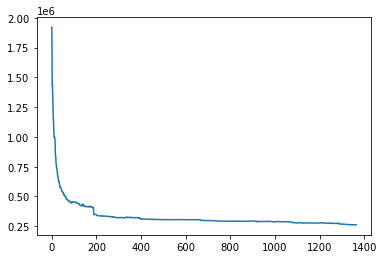

In [231]:
plt.plot(range(len(errs.values())), errs.values())

In [228]:
random_sensors = choose_sensors_random(power_graph, k=int(len(labeled_power_flows) / 2))
random_errs = {}

errs = {}

for i in tqdm(range(len(random_sensors))):
    preds = flow_prediction_nls(power_graph, {s: labeled_power_flows[s] for s in opt_sensors[:i]})
    errs[i] = mse(preds, labeled_power_flows)
    
    random_preds = flow_prediction_nls(power_graph, {s: labeled_power_flows[s] for s in random_sensors[:i]})
    random_errs[i] = mse(random_preds, labeled_power_flows)

  0%|          | 0/1364 [00:00<?, ?it/s]

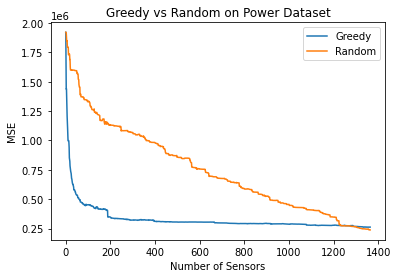

In [229]:
fig, ax = plt.subplots()
ax.plot(range(len(errs.values())), errs.values(), label="Greedy")
ax.plot(range(len(random_errs.values())), random_errs.values(), label="Random")
ax.legend()
plt.xlabel("Number of Sensors")
plt.ylabel("MSE")
plt.title("Greedy vs Random on Power Dataset")
plt.show()
# plt.plot(range(len(errs.values())), errs.values(), range(len(random_errs.values())), random_errs.values(), 
#          xlabel="Number of Sensors", ylabel="MSE")

### Other Traffic Networks

#### San Francisco

In [254]:
edgelist = pd.read_csv("out/sfc.results.csv")
edgelist.head()

,edge_id,edge_from,edge_to,edge_length,edge_numLanes,edge_speed,flow,vehicle_speed
0,0,663028776,32915539,85.856322,5,29.0576,2090.0,26.36
1,1,349678308,349678300,33.691470,2,29.0576,67.0,27.26
2,2,120816570,3971849316,13.396196,1,29.0576,0.0,0.00
3,3,31354482,31416669,174.514680,2,29.0576,767.0,17.33
4,4,62292066,62292068,20.349926,1,29.0576,0.0,0.00


In [255]:
G = nx.from_pandas_edgelist(edgelist, source="edge_from", target="edge_to", edge_attr=["edge_id", "edge_numLanes", "edge_speed",
                                                                                      "flow", "vehicle_speed"],
                           create_using=nx.DiGraph)

In [256]:
nodes = pd.read_csv("out/" + "sfc" + ".nodes.csv", sep=";").set_index("node_id")
nodes.head()

,node_x,node_y
node_id,,
1373634581,-122.108646,38.024515
1335885865,-122.291325,38.117516
3974627383,-122.515574,37.928089
3974627384,-122.515807,37.929306
767819860,-122.392965,37.704484


In [257]:
positions = {v: (k["node_x"], k["node_y"]) for v, k in nodes.to_dict("index").items()}
labeled_flows = get_labels_from_df(edgelist, 2, 3, -2)

In [258]:
len(labeled_flows)

40379

In [ ]:
opt_sensors = choose_sensors(G, labeled_flows, flow_prediction, mse, lazy=True, cores=8, k=5000)

In [ ]:
random_sensors = choose_sensors_random(G, k=5000)
random_errs = {}

errs = {}

for i in tqdm(range(len(random_sensors))):
    preds = flow_prediction_nls(G, {s: labeled_flows[s] for s in opt_sensors[:i]})
    errs[i] = mse(preds, labeled_flows) ** (1/2)
    
    random_preds = flow_prediction_nls(G, {s: labeled_flows[s] for s in random_sensors[:i]})
    random_errs[i] = mse(random_preds, labeled_flows) ** (1/2)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(errs.values())), errs.values(), label="Greedy")
ax.plot(range(len(random_errs.values())), random_errs.values(), label="Random")
ax.legend()
plt.xlabel("Number of Sensors")
plt.ylabel("RMSE")
plt.title("Greedy vs Random on SF Dataset")
plt.show()